In [1]:
import copy
import cv2
from datetime import datetime
from fastai import *
from fastai.vision import *
from fastai.vision.learner import *
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import time
import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms as TF
from torchvision.transforms import functional as F

In [2]:
from math import pi


class NFOV:
    def __init__(self, height=400, width=800, FOV=None):
        self.FOV = FOV or [0.45, 0.45]
        self.PI = pi
        self.PI_2 = pi * 0.5
        self.PI2 = pi * 2.0
        self.height = height
        self.width = width
        self.screen_points = self._get_screen_img()

    def _get_coord_rad_for_point(self, center_point):
        return (center_point * 2 - 1) * np.array([self.PI, self.PI_2])

    def _get_coord_rad(self):
        return (self.screen_points * 2 - 1) * np.array([self.PI, self.PI_2]) * (
                np.ones(self.screen_points.shape) * self.FOV)

    def _get_screen_img(self):
        xx, yy = np.meshgrid(np.linspace(0, 1, self.width), np.linspace(0, 1, self.height))
        return np.array([xx.ravel(), yy.ravel()]).T

    def _calcSphericaltoGnomonic(self, convertedScreenCoord):
        x = convertedScreenCoord.T[0]
        y = convertedScreenCoord.T[1]

        rou = np.sqrt(x ** 2 + y ** 2)
        c = np.arctan(rou)
        sin_c = np.sin(c)
        cos_c = np.cos(c)

        lat = np.arcsin(cos_c * np.sin(self.cp[1]) + (y * sin_c * np.cos(self.cp[1])) / rou)
        lon = self.cp[0] + np.arctan2(x * sin_c, rou * np.cos(self.cp[1]) * cos_c - y * np.sin(self.cp[1]) * sin_c)

        lat = (lat / self.PI_2 + 1.) * 0.5
        lon = (lon / self.PI + 1.) * 0.5

        return np.array([lon, lat]).T

    def _bilinear_interpolation(self, screen_coord, dt):
        uf = np.mod(screen_coord.T[0], 1) * self.frame_width  # long - width
        vf = np.mod(screen_coord.T[1], 1) * self.frame_height  # lat - height

        x0 = np.floor(uf).astype(int)  # coord of pixel to bottom left
        y0 = np.floor(vf).astype(int)
        x2 = np.add(x0, np.ones(uf.shape).astype(int))  # coords of pixel to top right
        y2 = np.add(y0, np.ones(vf.shape).astype(int))

        base_y0 = np.multiply(y0, self.frame_width)
        base_y2 = np.multiply(y2, self.frame_width)

        A_idx = np.add(base_y0, x0)
        B_idx = np.add(base_y2, x0)
        C_idx = np.add(base_y0, x2)
        D_idx = np.add(base_y2, x2)

        flat_img = np.reshape(self.frame, [-1, self.frame_channel]).astype(dt)

        A = np.take(flat_img, A_idx, axis=0)
        B = np.take(flat_img, B_idx, axis=0)
        C = np.take(flat_img, C_idx, axis=0)
        D = np.take(flat_img, D_idx, axis=0)

        wa = np.multiply(x2 - uf, y2 - vf)
        wb = np.multiply(x2 - uf, vf - y0)
        wc = np.multiply(uf - x0, y2 - vf)
        wd = np.multiply(uf - x0, vf - y0)

        waf = np.array([wa for _ in range(self.frame_channel)]).T
        wbf = np.array([wb for _ in range(self.frame_channel)]).T
        wcf = np.array([wc for _ in range(self.frame_channel)]).T
        wdf = np.array([wd for _ in range(self.frame_channel)]).T

        # interpolate
        AA = np.multiply(A, waf)
        BB = np.multiply(B, wbf)
        CC = np.multiply(C, wcf)
        DD = np.multiply(D, wdf)
        nfov = np.reshape((AA + BB + CC + DD).astype(dt), [self.height, self.width, self.frame_channel])
        return nfov

    def toNFOV(self, frame, center_point, dt='uint8'):
        self.frame = frame.astype(dt)
        self.frame_height = frame.shape[0]
        self.frame_width = frame.shape[1]
        self.frame_channel = frame.shape[2]
        
        self.cp = self._get_coord_rad_for_point(center_point)
        convertedScreenCoord = self._get_coord_rad()
        spericalCoord = self._calcSphericaltoGnomonic(convertedScreenCoord)
        return self._bilinear_interpolation(spericalCoord, dt)

    def convert(self, image, point, dt='uint8'):
        w, h = point
        return self.toNFOV(image, np.array([w, h]), dt)

In [3]:
hdr_dir = r'C:\Users\ovechkinve\IndoorHDRDataset2018'
base_dir = r'C:\Users\ovechkinve\itmo\hdr_out'

hdr_crops_dir = os.path.join(base_dir, 'crops_hdr')
ldr_crops_dir = os.path.join(base_dir, 'crops_ldr')
labels_file = os.path.join(base_dir, 'labels.csv')

In [4]:
img_path = os.path.join(hdr_dir, os.listdir(hdr_dir)[0])
hdr_images = [os.path.join(hdr_dir, image_name) for image_name in os.listdir(hdr_dir)]
print(img_path)
print(len(hdr_images))

C:\Users\ovechkinve\IndoorHDRDataset2018\9C4A0003-e05009bcad.exr
2233


In [5]:
def gamma_correction(img, gamma=5):
    return np.clip(np.power(img, 1.0 / gamma), 0.0, 1.0).astype(np.float32)


def to_ldr(img_hdr, gamma=2.2):
    tonemap = cv2.createTonemapReinhard(gamma, 0, 0, 0)
    return (tonemap.process(img_hdr) * 255).astype(np.uint8)


def read_hdr(path):
    hdr_img = cv2.imread(path, cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
    return cv2.cvtColor(hdr_img, cv2.COLOR_BGR2RGB).astype('float32')


def write_hdr(path, hdr_img):
    hdr_bgr = cv2.cvtColor(hdr_img, cv2.COLOR_RGB2BGR).astype('float32')
    cv2.imwrite(path, hdr_bgr, [cv2.IMWRITE_EXR_TYPE_FLOAT])

In [6]:
def light_sources_mask(hdr_image):
    treshold = np.percentile(hdr_image, 99)
    mask_rgb = (hdr_image > treshold).astype(np.uint8)
    mask = np.max(mask_rgb, axis=2)
    return mask

In [7]:
def show_light(hdr_img):
    img = to_ldr(hdr_img.copy())

    mask = light_sources_mask(hdr_img)
    mask_rgb = np.stack([mask for _ in range(3)], axis=2)
    img1 = img * (1 - mask_rgb) + mask_rgb * np.array([0, 255, 255])

    fig = plt.figure(figsize=(15, 8))
    plt.imshow(img1)
    plt.show()

In [72]:
def to_pil(cv2_img):
    cv2_img1 = cv2.cvtColor(cv2_img.copy(), cv2.COLOR_BGR2RGB)
    return Image.fromarray(cv2_img1)

def from_pil(pil_img):
    img = np.array(pil_img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img


def adjust_image_param(img, func, lower_value, higher_value):
    original_image = to_pil(img)

    lower_param_image = func(original_contrast.copy(), lower_value)
    higher_param_image = func(original_contrast.copy(), higher_value)

    composed_contrast_adjusted = np.concatenate(
        list(map(from_pil, [lower_param_image, original_image, higher_param_image])),
        axis=1)
    show_ldr(composed_contrast_adjusted)

In [128]:
nfov = NFOV(height=512, width=384, FOV=[0.30, 0.90])

nfov_h = NFOV(height=512, width=384, FOV=[0.20, 0.60])
nfov_w = NFOV(height=1024, width=2048, FOV=[0.75, 0.75])

def crop(img, point, dt='uint8'):
    cropped = nfov.toNFOV(img, point, dt)
    return cv2.resize(cropped, (nfov.width, nfov.height)).astype(dt)


def crop1(nfover, img, point, dt='uint8'):
    cropped = nfover.toNFOV(img, point, dt)
    return cv2.resize(cropped, (nfover.width, nfover.height)).astype(dt)


def crop_pair(img, point, dt='uint8'):
    cropped_w = crop1(nfov_w, img, point, dt)
    cropped_h = crop1(nfov_h, img, point, dt)
    return (cropped_w, cropped_h)


n_crops = 5


def crop_points():
    w = np.random.random(size=(n_crops, 1))
    h = np.random.random(size=(n_crops, 1)) * 0.35 + 0.2
    return np.concatenate((w, h), axis=1)


def crop_point1():
    w = np.random.random()
    h = np.random.random() * 0.35 + 0.2
    return np.array([w, h])

def random_fov_crop(img):
    return crop1(nfov_w, img, crop_point1())

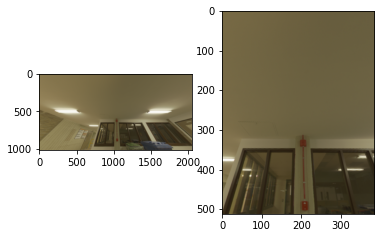

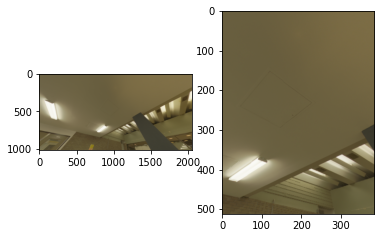

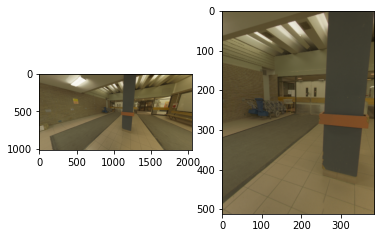

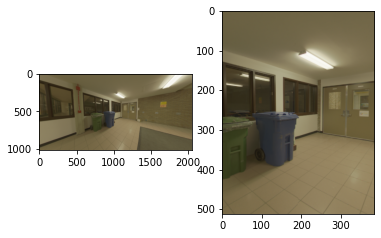

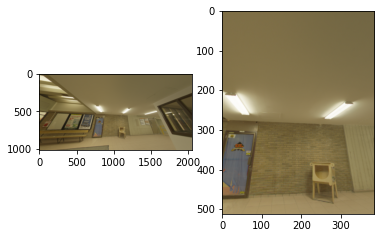

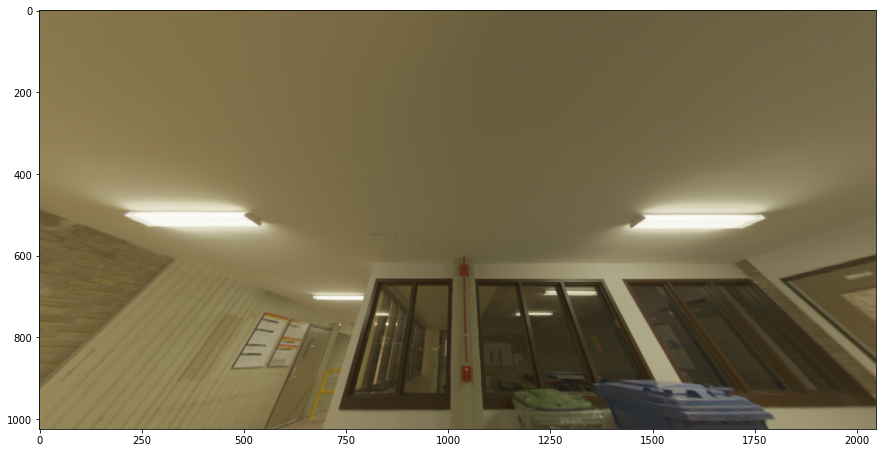

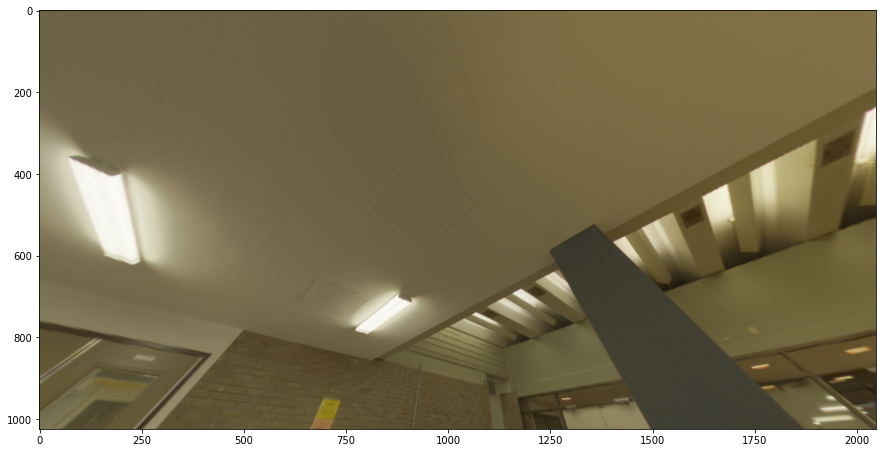

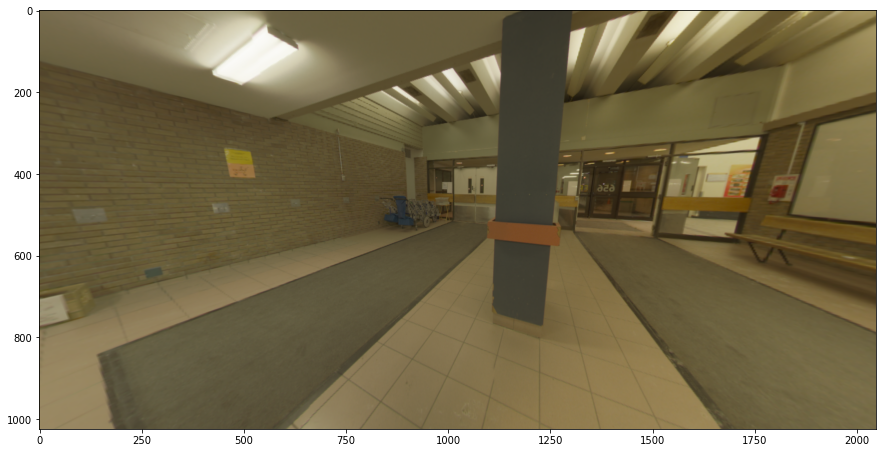

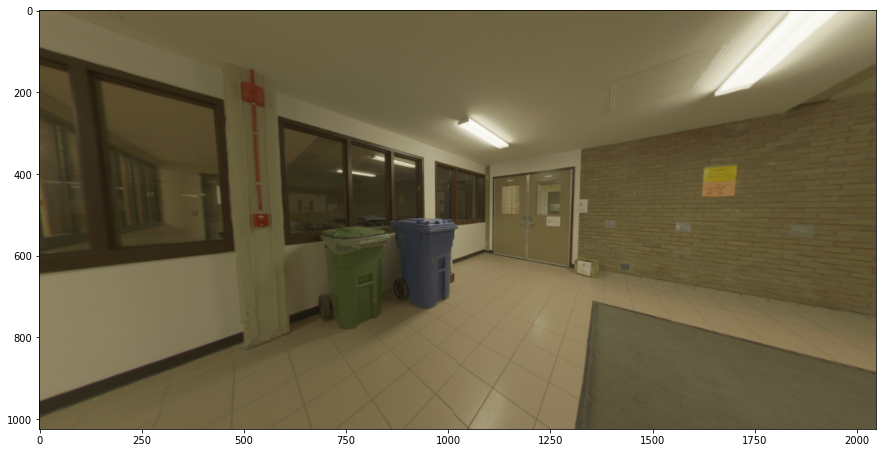

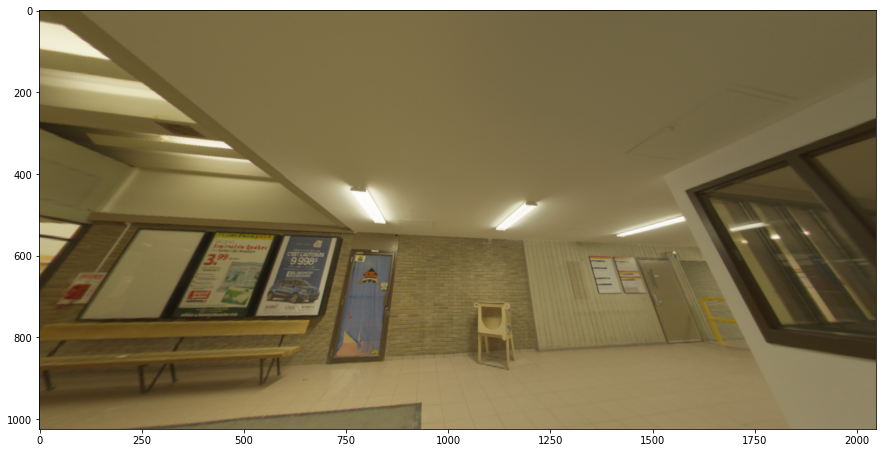

In [66]:
np.random.seed(1338)

hdr_img = read_hdr(img_path)
ldr_img = to_ldr(hdr_img.copy())

ldr_img = cv2.resize(ldr_img, (2048, 1024), interpolation = cv2.INTER_CUBIC)

# pil_img = F.to_pil_image(ldr_img)

crop_points1 = crop_points()
# cropped = [crop(ldr_img.copy(), point) for point in crop_points1]
# composite = np.concatenate(cropped, axis=1)

cropped_pairs = [crop_pair(ldr_img.copy(), point) for point in crop_points1]
# composite = np.concatenate(cropped, axis=1)

for pair in cropped_pairs:
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.imshow(pair[0])
    ax2.imshow(pair[1])
    plt.show()

for pair in cropped_pairs:
    fig = plt.figure(figsize=(15, 15))
    plt.imshow(pair[0])
    plt.show()

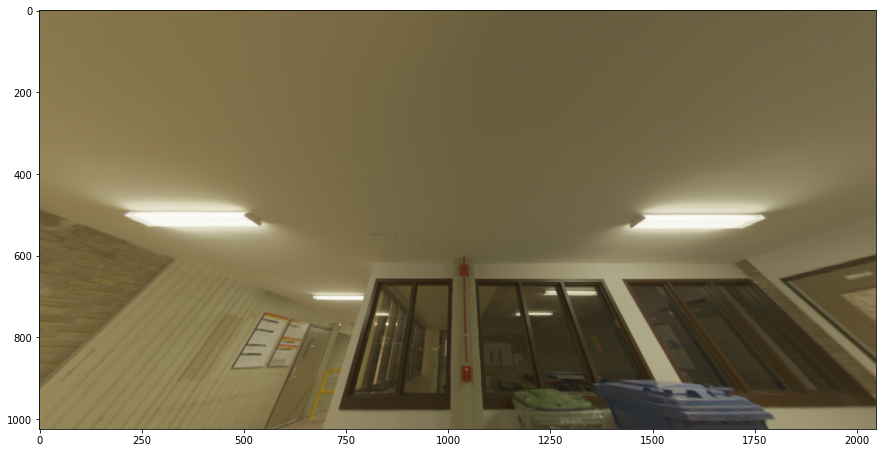

(96, 1502, 512, 384)


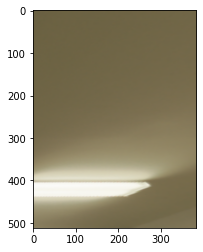

In [93]:
np.random.seed(1338)

img12 = cropped_pairs[0][0]
fig = plt.figure(figsize=(15, 15))
plt.imshow(img12)
plt.show()

pil_img12 = to_pil(img12)
out_size = (512, 384)

params = TF.RandomCrop.get_params(pil_img12.copy(), out_size)
print(params)

cropped12 = F.crop(pil_img12.copy(), *params)
plt.imshow(from_pil(cropped12))
plt.show()

In [175]:
np.random.seed(1337)

subdir_name = datetime.now().strftime("%d %b %H_%M_%S")
subdir = os.path.join(base_dir, subdir_name)

if not os.path.exists(subdir):
    os.mkdir(subdir)

# hdr_crops_dir = os.path.join(subdir, 'crops_hdr')
# if not os.path.exists(hdr_crops_dir):
#     os.mkdir(hdr_crops_dir)

ldr_crops_dir = os.path.join(subdir, 'crops_ldr')
if not os.path.exists(ldr_crops_dir):
    os.mkdir(ldr_crops_dir)

labels_file = os.path.join(subdir, 'labels.csv')

WIMG_SIZE = (1024, 2048)
HIMG_SIZE = (512, 384)

PROD = True

all_images = hdr_images if PROD else hdr_images[:3]

with open(labels_file, 'w') as labels:
    labels.write('image_name,light_percentage,brightness_mean,brightness_std\n')
    
    for image_path in all_images:
        name, _ = os.path.basename(image_path).split('.')
        h, w = WIMG_SIZE
        
        try:
            hdr_img = read_hdr(image_path)

            hdr_img = cv2.resize(hdr_img, WIMG_SIZE, interpolation = cv2.INTER_CUBIC)
#             hdr_grayscale_img = cv2.cvtColor(hdr_img, cv2.COLOR_BGR2GRAY)
#             hdr_grayscale_img = hdr_grayscale_img.reshape((WIMG_SIZE[0], WIMG_SIZE[1], 1))

            light_treshold = np.percentile(hdr_grayscale_img, 99)

            points = crop_points()
            cropped_hdrs = [crop1(nfov_w, hdr_img.copy(), point, dt='float32') for point in points]
#             cropped_grayscale_hdrs = [crop1(nfov_w, hdr_grayscale_img.copy(), point, dt='float32') for point in points]
            
            for i, cropped_hdr in enumerate(cropped_hdrs):
                cropped_grayscale_hdr = cv2.cvtColor(cropped_hdr, cv2.COLOR_BGR2GRAY)
                
                new_name = f'{name}_{i}'
#                 cropped_hdr_path = os.path.join(hdr_crops_dir, f'{new_name}.exr')
                cropped_ldr_path = os.path.join(ldr_crops_dir, f'{new_name}.png')
                cropped_ldr = to_ldr(cropped_hdr)
                cropped_ldr_rgba = cv2.cvtColor(cropped_ldr, cv2.COLOR_BGR2RGBA)
            
                (si, sj, sh, sw) = TF.RandomCrop.get_params(to_pil(cropped_ldr), HIMG_SIZE)
                subcrop_mask = np.zeros(WIMG_SIZE)
                subcrop_mask[si:si+sh, sj:sj+sw] = 255
                cropped_ldr_rgba[:,:,3] = subcrop_mask
                
                subcropped_grayscale_hdr = cropped_grayscale_hdr[si:si+sh, sj:sj+sw]

                brightness_mean = np.mean(subcropped_grayscale_hdr)
                brightness_std = np.std(subcropped_grayscale_hdr)

                light_mask = (subcropped_grayscale_hdr > light_treshold).astype(np.uint8)
                percent_of_light = np.sum(light_mask) / (HIMG_SIZE[0] * HIMG_SIZE[1])

                label = f'{new_name},{percent_of_light:.3f},{brightness_mean:.4f},{brightness_std:.4f}\n'
                labels.write(label)

                if not PROD:
#                     light_mask_rgb = np.stack([light_mask for _ in range(3)], axis=2)

                    print(label, end='')
#                     fig = plt.figure(figsize=(10, 10))
#                     ldr_img1 = cropped_ldr * (1 - light_mask_rgb) + light_mask_rgb * np.array([0, 255, 255])
#                     ldr_img2 = np.concatenate([cropped_ldr, ldr_img1], axis=1)
#                     plt.imshow(ldr_img2)
#                     plt.show()
                    fig = plt.figure(figsize=(10, 10))
                    cropped_ldr_all = cv2.cvtColor(cropped_ldr, cv2.COLOR_BGR2BGRA)
                    cropped_ldr_bgra = cv2.cvtColor(cropped_ldr_rgba, cv2.COLOR_RGBA2BGRA)
#                     cropped_ldr_all[:,:,3] = np.ones(WIMG_SIZE)
                    to_show = np.concatenate([cropped_ldr_all, cropped_ldr_bgra], axis=0)
                    plt.imshow(to_show)
                    plt.show()
            
                    fig1 = plt.figure(figsize=(10, 10))
                    plt.imshow(gamma_correction(subcropped_grayscale_hdr))
                    plt.show()

#                 write_hdr(cropped_hdr_path, cropped_hdr)
                cv2.imwrite(cropped_ldr_path, cropped_ldr_rgba)
        except Exception as e:
            print(e)
            if not PROD:
                raise e
